In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def kelly(decimal_odds, P, fractional):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * fractional
    return solution

In [129]:
def backtest(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    #df = df[df['Sportsbooks_Odds'] < 2.00]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    plt.title('PnL Over Time')
    
    plt.show()  # Show the first plot
    
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], track, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Bankroll($)', size=17)
    plt.title('Bankroll Over Time')
    
    plt.show()
    
    print('\n')
    print(f'The position was held for 2 months, traded {periods} times, and produced a return of {final_return:.4f}%.')
    print(f'The growth rate on each bet was {returns:.4f}%.')
    print(f'The final balance is ${balance}.')
    print(f'The average of returns is {avg_return:.4f}%.')
    print(f'The standard deviation of returns is {returns_std:.4f}%.')
    print('\n')
    #print(track)
    print(f'The Sharpe Ratio of the strategy is {sharpe_ratio:.4f}.')

In [130]:
def backtest_for_sharpe(df,initial, shrinkage, threshold):
    df = df.copy()
    df = df[df['Sportsbooks_Odds'] > threshold]
    df.loc[:, 'Kelly'] = kelly(df['Sportsbooks_Odds'], df['Probabilities'], shrinkage)
    
    df = df[df['Kelly'] > 0].reset_index(drop=True)
    df = df.sort_values(by='Date')
    balance = initial
    pnl = []
    track = []
    returns_list = [] 
    
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Sportsbooks_Odds'] - 1)
            balance += profit
            pnl.append(profit)
            track.append(balance)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
            track.append(balance)
        if index > 0:
            returns_list.append((balance / initial - 1) * 100)
            
    returns_std = np.std(returns_list)
    avg_return = np.mean(returns_list)
    sharpe_ratio = (avg_return / returns_std)
    
    balance = round(balance, 2)
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns* 100, 4) 
    final_return = ((balance / initial) - 1) * 100
    
    return sharpe_ratio

In [131]:
save_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management/"
file_name = "calibrated_2024_predictions.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [142]:
max_odds_columns = odds.iloc[:, 2:5].idxmax(axis=1)
best_odds = []

for index,row in odds.iterrows():
    best_odds.append(row[max_odds_columns[index]])

max_odds = pd.DataFrame({
    'Date': odds['Timestamp'],
    'Teams': odds['Teams_x'],
    'Sportsbooks_Odds': best_odds
})

final = pd.merge(df, max_odds, on=['Date', 'Teams'], how='left')
final['Our_Odds'] = 1 / final['Probabilities']
column_order = ['Date', 'Teams', 'Sportsbooks_Odds','Our_Odds','Probabilities','Predictions', 'Actual']
#'Our_Odds',
final = final[column_order]
win = final[final['Predictions'] == 1]
bet = win[win['Our_Odds'] < win['Sportsbooks_Odds']]

In [138]:
len(bet[bet['Sportsbooks_Odds'] > 1.50])

110

In [150]:
gap = bet[bet['Sportsbooks_Odds'] - bet['Our_Odds'] > 0.20]
gap = gap.reset_index(drop=True)

In [151]:
gap

,Date,Teams,Sportsbooks_Odds,Our_Odds,Probabilities,Predictions,Actual
0,2024-01-03,ATL,1.95,1.619048,0.617647,1,1
1,2024-01-03,MEM,1.87,1.661017,0.602041,1,0
2,2024-01-12,PHI,1.87,1.661017,0.602041,1,1
3,2024-01-13,LAL,1.87,1.619048,0.617647,1,0
4,2024-01-14,MIN,2.10,1.840000,0.543478,1,1
5,2024-01-15,LAL,1.95,1.661017,0.602041,1,1
6,2024-01-24,DAL,2.20,1.840000,0.543478,1,0
7,2024-01-26,OKC,2.00,1.661017,0.602041,1,1
8,2024-01-28,ORL,2.00,1.679269,0.595497,1,1
9,2024-01-29,CLE,2.12,1.840000,0.543478,1,1


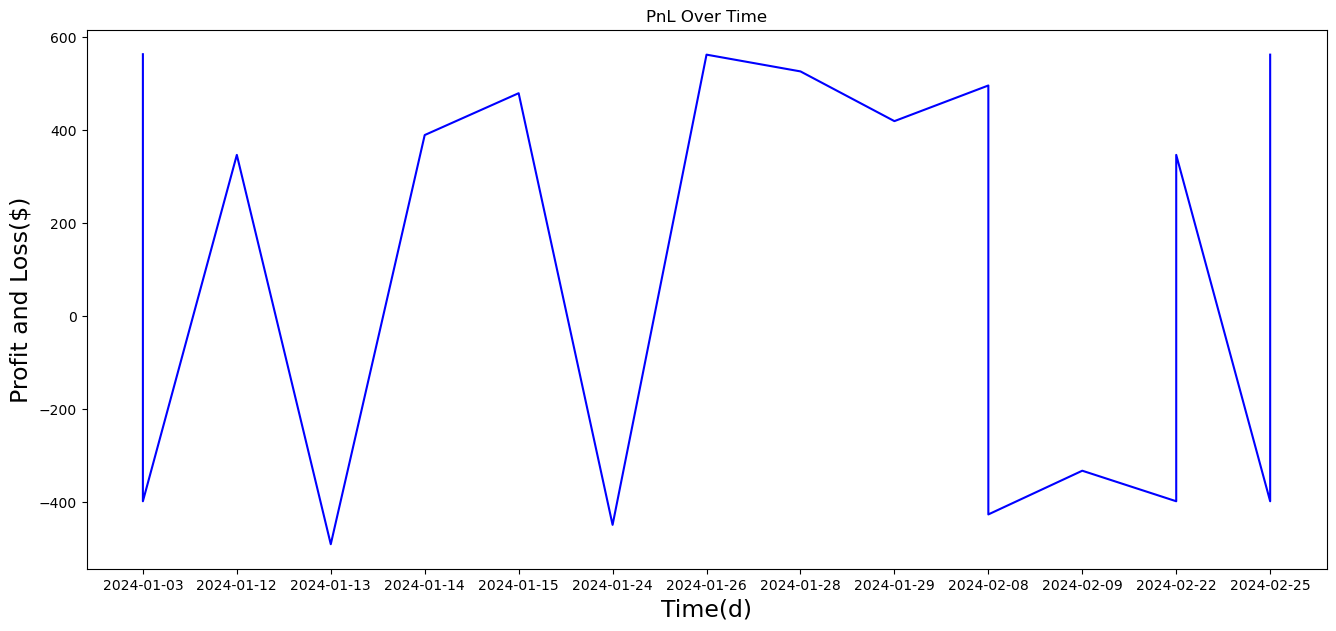

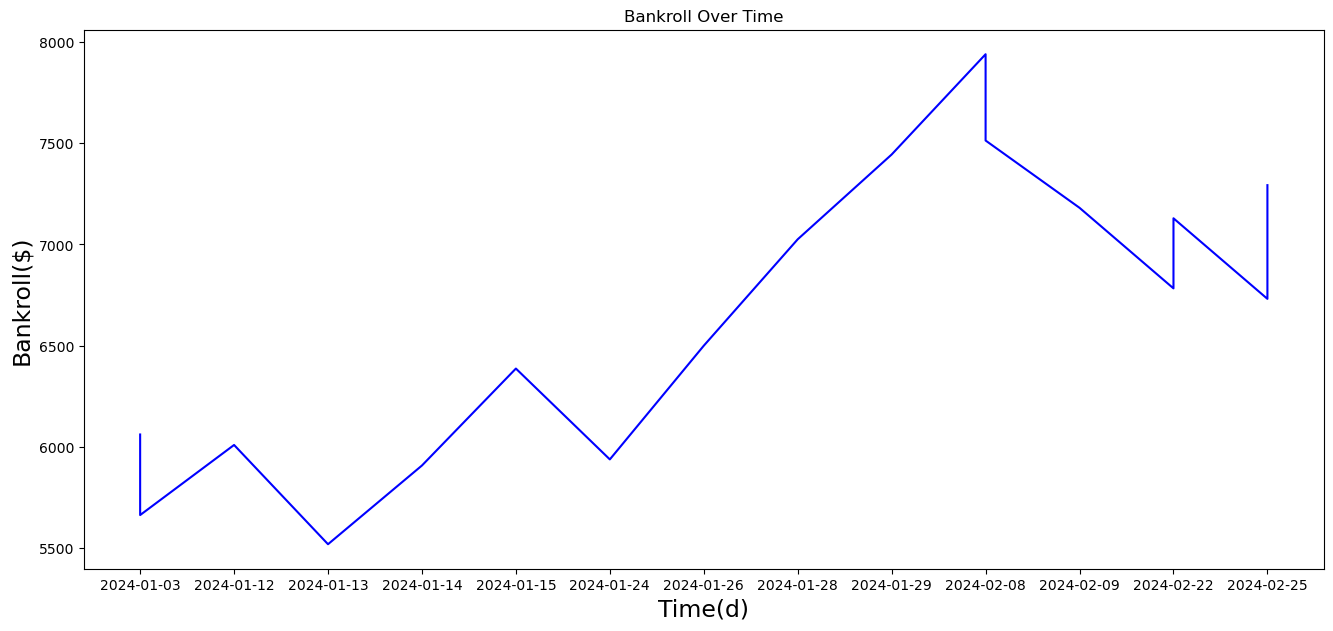



The position was held for 2 months, traded 17 times, and produced a return of 32.5969%.
The growth rate on each bet was 1.6735%.
The final balance is $7292.83.
The average of returns is 21.5584%.
The standard deviation of returns is 12.7832%.


The Sharpe Ratio of the strategy is 1.6865.


In [153]:
backtest(gap, 5500, 0.5, 0)

In [92]:
greatest_sharp = 0
best_threshold = 0
best_return = 0 
traded = 0

for i in range(100, 200):
    threshold = i / 100
    sharp = backtest_for_sharpe(bet, 6000, 0.5, threshold)
    if sharp > greatest_sharp and len(bet[bet['Sportsbooks_Odds'] > threshold]) > 1:
        greatest_sharp = sharp
        best_threshold = threshold
        traded = len(bet[bet['Sportsbooks_Odds'] > threshold])
print(f'The greatest sharpe ratio is: {greatest_sharp}')
print(f'The odds threshold is: {best_threshold}')
print(f'The algoritm traded: {traded} times')

The greatest sharpe ratio is: 2.7926135072345812
The odds threshold is: 1.87
The algoritm traded: 18 times
